In [1]:
from scipy import stats
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    balanced_accuracy_score,
    f1_score)
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding, Input
from keras_preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.metrics import classification_report
import statsmodels.api as sm
from sklearn.model_selection import KFold, cross_val_score
from scipy.stats import chi2_contingency
import tkinter as tk
from tkinter import messagebox

2023-05-02 08:39:38.378060: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
np.random.seed(833)

In [3]:
#uploading csv file
maternal="Maternal_Dataset.csv"

In [4]:
dataframe=pd.read_csv(maternal,header=0,delimiter=',')

In [5]:
print(dataframe.shape)

(1014, 7)


In [6]:
print(dataframe.head())

   Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel
0   25         130           80  15.0      98.0         86  high risk
1   35         140           90  13.0      98.0         70  high risk
2   29          90           70   8.0     100.0         80  high risk
3   30         140           85   7.0      98.0         70  high risk
4   35         120           60   6.1      98.0         76   low risk


In [7]:
#preprocessing
#checking for missing values
print(np.any(pd.isnull(dataframe)))

False


In [8]:
missing_values = dataframe.isna()

# Use the sum() method to count the number of missing values in each column
missing_counts = missing_values.sum()

# Print the number of missing values in each column
print(missing_counts)

Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64


In [9]:
print("Missing values in each column:")
for column in dataframe.columns:
    num_missing = dataframe[column].isna().sum()
    if num_missing > 0:
        print(f"{column}: {num_missing}")

Missing values in each column:


In [10]:
"""import statsmodels.api as sm
# Fit a linear regression model with an identity link function (which is equivalent to OLS)
X = sm.add_constant(X)  # add a constant column to include the intercept
model = sm.GLM(y, X, family=sm.families.Gaussian())
results = model.fit()

# Print the model summary
print(results.summary())"""

'import statsmodels.api as sm\n# Fit a linear regression model with an identity link function (which is equivalent to OLS)\nX = sm.add_constant(X)  # add a constant column to include the intercept\nmodel = sm.GLM(y, X, family=sm.families.Gaussian())\nresults = model.fit()\n\n# Print the model summary\nprint(results.summary())'

In [11]:
# create cross-tabulation of dependent variable and each independent variable
crosstab_var1 = pd.crosstab(dataframe['RiskLevel'], pd.qcut(dataframe['Age'], 3))
crosstab_var2 = pd.crosstab(dataframe['RiskLevel'], pd.qcut(dataframe['SystolicBP'], 3))
crosstab_var3 = pd.crosstab(dataframe['RiskLevel'], pd.qcut(dataframe['DiastolicBP'], 3))
crosstab_var4 = pd.crosstab(dataframe['RiskLevel'], pd.qcut(dataframe['BS'], 3))
crosstab_var5 = pd.crosstab(dataframe['RiskLevel'], pd.qcut(dataframe['BodyTemp'], 3, duplicates='drop'))
crosstab_var6 = pd.crosstab(dataframe['RiskLevel'], pd.qcut(dataframe['HeartRate'], 3))

# perform chi-squared test for each variable
_, pval_var1, _, _ = chi2_contingency(crosstab_var1)
_, pval_var2, _, _ = chi2_contingency(crosstab_var2)
_, pval_var3, _, _ = chi2_contingency(crosstab_var3)
_, pval_var4, _, _ = chi2_contingency(crosstab_var4)
_, pval_var5, _, _ = chi2_contingency(crosstab_var5)
_, pval_var6, _, _ = chi2_contingency(crosstab_var6)

# print results
print(f"P-value for Age: {pval_var1}")
print(f"P-value for Systolic BP: {pval_var2}")
print(f"P-value for Diastolic BP: {pval_var3}")
print(f"P-value for Blood Sugar: {pval_var4}")
print(f"P-value for Body Temp: {pval_var5}")
print(f"P-value for Heart Rate: {pval_var6}")

P-value for Age: 2.6736923848642334e-27
P-value for Systolic BP: 6.754697513924129e-63
P-value for Diastolic BP: 1.939678224483313e-26
P-value for Blood Sugar: 1.7623837447025307e-89
P-value for Body Temp: 1.0
P-value for Heart Rate: 5.851722841931894e-12


In [12]:
print(dataframe.head())
print(dataframe.shape)
print(dataframe.dtypes)

   Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel
0   25         130           80  15.0      98.0         86  high risk
1   35         140           90  13.0      98.0         70  high risk
2   29          90           70   8.0     100.0         80  high risk
3   30         140           85   7.0      98.0         70  high risk
4   35         120           60   6.1      98.0         76   low risk
(1014, 7)
Age              int64
SystolicBP       int64
DiastolicBP      int64
BS             float64
BodyTemp       float64
HeartRate        int64
RiskLevel       object
dtype: object


In [13]:
print(dataframe.describe())

               Age   SystolicBP  DiastolicBP           BS     BodyTemp  \
count  1014.000000  1014.000000  1014.000000  1014.000000  1014.000000   
mean     29.871795   113.198225    76.460552     8.725986    98.665089   
std      13.474386    18.403913    13.885796     3.293532     1.371384   
min      10.000000    70.000000    49.000000     6.000000    98.000000   
25%      19.000000   100.000000    65.000000     6.900000    98.000000   
50%      26.000000   120.000000    80.000000     7.500000    98.000000   
75%      39.000000   120.000000    90.000000     8.000000    98.000000   
max      70.000000   160.000000   100.000000    19.000000   103.000000   

         HeartRate  
count  1014.000000  
mean     74.301775  
std       8.088702  
min       7.000000  
25%      70.000000  
50%      76.000000  
75%      80.000000  
max      90.000000  


In [14]:
print(dataframe.corr())

                  Age  SystolicBP  DiastolicBP        BS  BodyTemp  HeartRate
Age          1.000000    0.416045     0.398026  0.473284 -0.255323   0.079798
SystolicBP   0.416045    1.000000     0.787006  0.425172 -0.286616  -0.023108
DiastolicBP  0.398026    0.787006     1.000000  0.423824 -0.257538  -0.046151
BS           0.473284    0.425172     0.423824  1.000000 -0.103493   0.142867
BodyTemp    -0.255323   -0.286616    -0.257538 -0.103493  1.000000   0.098771
HeartRate    0.079798   -0.023108    -0.046151  0.142867  0.098771   1.000000


In [15]:
#assigning dependent variable
y=dataframe[['RiskLevel']]
print(y.shape)
print(y.head())

(1014, 1)
   RiskLevel
0  high risk
1  high risk
2  high risk
3  high risk
4   low risk


In [16]:
display(pd.crosstab(y['RiskLevel'],'RiskLevel'))

col_0,RiskLevel
RiskLevel,
high risk,272
low risk,406
mid risk,336


In [17]:
#Reshaping into binary
y_2=(y=='low risk')
print(y_2)
display(pd.crosstab(y_2["RiskLevel"],"RiskLevel"))

      RiskLevel
0         False
1         False
2         False
3         False
4          True
...         ...
1009      False
1010      False
1011      False
1012      False
1013      False

[1014 rows x 1 columns]


col_0,RiskLevel
RiskLevel,
False,608
True,406


In [18]:
#assigning independent variable
X=dataframe.iloc[:,0:6]
print(X.shape)
print(X.head())

(1014, 6)
   Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate
0   25         130           80  15.0      98.0         86
1   35         140           90  13.0      98.0         70
2   29          90           70   8.0     100.0         80
3   30         140           85   7.0      98.0         70
4   35         120           60   6.1      98.0         76


In [19]:
#splitting the dataset into training and test sets
X_train,X_test,y_train,y_test=X[:710], X[710:], y_2[:710], y_2[710:]

In [20]:
#print(X_train.shape)
#print(X_test.shape)
#print(y_train.shape)
#print(y_test.shape)

In [21]:
display(pd.crosstab(y['RiskLevel'],'RiskLevel'))

col_0,RiskLevel
RiskLevel,
high risk,272
low risk,406
mid risk,336


In [22]:
display(pd.crosstab(y_2['RiskLevel'],'RiskLevel'))

col_0,RiskLevel
RiskLevel,
False,608
True,406


In [23]:
display(pd.crosstab(y_train['RiskLevel'],'RiskLevel'))

col_0,RiskLevel
RiskLevel,
False,382
True,328


In [24]:
display(pd.crosstab(y_test['RiskLevel'],'RiskLevel'))

col_0,RiskLevel
RiskLevel,
False,226
True,78


In [25]:
######CROSS-VALIDATION######

In [26]:
#K NEAREST NEIGHBORS
#K=4
knn_clf=KNeighborsClassifier(weights='distance',n_neighbors=4)
knn_clf.fit(X_train,y_train.values.ravel())

k_folds = KFold(n_splits = 5)

scores = cross_val_score(knn_clf, X_train, y_train, cv = k_folds)

print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ", len(scores))

Cross Validation Scores:  [0.95774648 0.78873239 0.79577465 0.67605634 0.73239437]
Average CV Score:  0.7901408450704225
Number of CV Scores used in Average:  5


/Users/geraldgaitos/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/geraldgaitos/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/geraldgaitos/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/geraldgaitos/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:2

In [27]:
y_knn_pred=knn_clf.predict(X_test)

In [28]:
#accuracy score K=4
accuracy_score(y_test,y_knn_pred)

0.9375

In [29]:
#balanced accuracry score
balanced_accuracy_score(y_test,y_knn_pred)

0.8866008622645791

In [30]:
#confusion matrix
conf_mx=confusion_matrix(y_test,y_knn_pred)
conf_mx

array([[224,   2],
       [ 17,  61]])

In [31]:
tab_test=pd.crosstab(index=y_test['RiskLevel'],columns='count')
tab_train=pd.crosstab(index=y_train['RiskLevel'],columns='count')

<AxesSubplot:xlabel='RiskLevel'>

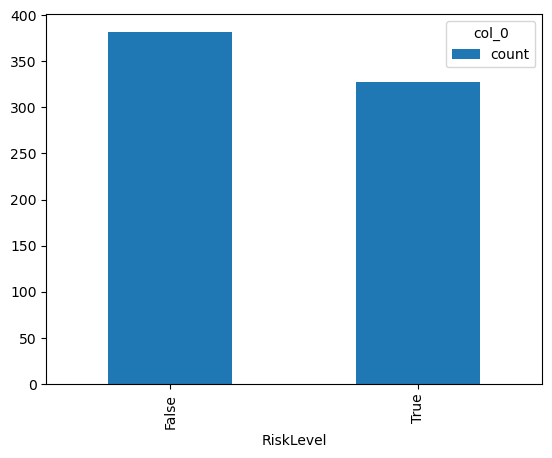

In [32]:
tab_train.plot.bar()

<AxesSubplot:xlabel='RiskLevel'>

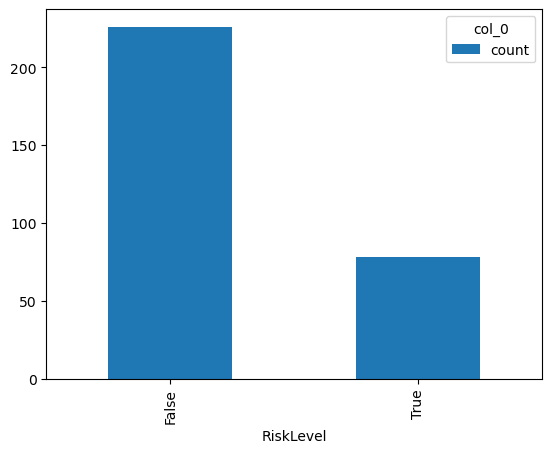

In [33]:
tab_test.plot.bar()

In [34]:
#KNN GridSearchCV
param_grid=[{"weights":["uniform","distance"],"n_neighbors":[1,2,3,4,5,6,7]}]

In [35]:
knn_clf=KNeighborsClassifier()

In [36]:
grid_search=GridSearchCV(knn_clf,param_grid,cv=5,verbose=3)

In [37]:
grid_search.fit(X_train,y_train.values.ravel())

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV 1/5] END ....n_neighbors=1, weights=uniform;, score=0.908 total time=   0.0s
[CV 2/5] END ....n_neighbors=1, weights=uniform;, score=0.810 total time=   0.0s
[CV 3/5] END ....n_neighbors=1, weights=uniform;, score=0.746 total time=   0.0s
[CV 4/5] END ....n_neighbors=1, weights=uniform;, score=0.704 total time=   0.0s
[CV 5/5] END ....n_neighbors=1, weights=uniform;, score=0.648 total time=   0.0s
[CV 1/5] END ...n_neighbors=1, weights=distance;, score=0.908 total time=   0.0s
[CV 2/5] END ...n_neighbors=1, weights=distance;, score=0.810 total time=   0.0s
[CV 3/5] END ...n_neighbors=1, weights=distance;, score=0.746 total time=   0.0s
[CV 4/5] END ...n_neighbors=1, weights=distance;, score=0.704 total time=   0.0s
[CV 5/5] END ...n_neighbors=1, weights=distance;, score=0.648 total time=   0.0s
[CV 1/5] END ....n_neighbors=2, weights=uniform;, score=0.852 total time=   0.0s
[CV 2/5] END ....n_neighbors=2, weights=uniform;

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [1, 2, 3, 4, 5, 6, 7],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [38]:
grid_search.best_params_

{'n_neighbors': 3, 'weights': 'distance'}

In [39]:
grid_search.best_score_

0.7845070422535211

In [40]:
y_pred=grid_search.predict(X_test)

In [41]:
accuracy_score(y_test,y_pred)

0.9375

In [42]:
balanced_accuracy_score(y_test,y_knn_pred)

0.8866008622645791

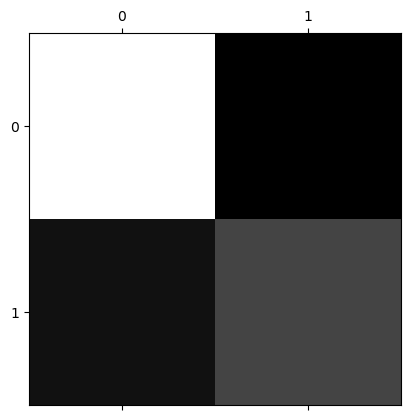

In [43]:
plt.matshow(conf_mx,cmap=plt.cm.gray)

In [44]:
#NAIVE-BAYES
gnb=GaussianNB()
nb_pred=gnb.fit(X_train,y_train.values.ravel())

k_folds = KFold(n_splits = 5)

scores = cross_val_score(nb_pred, X_train, y_train, cv = k_folds)

print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ", len(scores))

Cross Validation Scores:  [0.68309859 0.85915493 0.69014085 0.72535211 0.73943662]
Average CV Score:  0.7394366197183099
Number of CV Scores used in Average:  5


/Users/geraldgaitos/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/geraldgaitos/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/geraldgaitos/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/geraldgaitos/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: D

In [45]:
#NAIVE-BAYES
gnb=GaussianNB()
nb_pred=gnb.fit(X_train,y_train.values.ravel())
nb_predicted=nb_pred.predict(X_test)

In [46]:
#accuracy score
accuracy_score(y_test,nb_predicted,normalize=True)

0.5625

In [47]:
#balanced accuracy score
balanced_accuracy_score(y_test,nb_predicted)

0.6637735420921261

In [48]:
conf_mx=confusion_matrix(y_test,nb_predicted)
display(conf_mx)

array([[103, 123],
       [ 10,  68]])

In [49]:
#SUPPORT VECTOR MACHINE
# Define the SVM model with a poly kernel
svm_model = SVC(kernel='poly')
svm_model.fit(X_train, y_train.values.ravel())

k_folds = KFold(n_splits = 5)

scores = cross_val_score(svm_model, X_train, y_train, cv = k_folds)

print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ", len(scores))

/Users/geraldgaitos/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/geraldgaitos/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Cross Validation Scores:  [0.76056338 0.87323944 0.64788732 0.80985915 0.71830986]
Average CV Score:  0.7619718309859155
Number of CV Scores used in Average:  5


/Users/geraldgaitos/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/geraldgaitos/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/geraldgaitos/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [50]:
# Fit the model to the training data
svm_model.fit(X_train, y_train.values.ravel())

# Make predictions on the testing data
y_pred = svm_model.predict(X_test)

In [51]:
# Calculate the accuracy of the model
accuracy_score(y_test, y_pred)

0.6414473684210527

In [52]:
#balanced accuracy score
balanced_accuracy_score(y_test,y_pred)

0.7126730201951441

In [53]:
conf_mx=confusion_matrix(y_test,y_pred)
display(conf_mx)

array([[128,  98],
       [ 11,  67]])

In [54]:
#Define the SVM model with a linear kernel
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train.values.ravel())

k_folds = KFold(n_splits = 5)

scores = cross_val_score(svm_model, X_train, y_train, cv = k_folds)

print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ", len(scores))

/Users/geraldgaitos/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/geraldgaitos/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/geraldgaitos/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/geraldgaitos/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: D

Cross Validation Scores:  [0.65492958 0.87323944 0.68309859 0.75352113 0.71830986]
Average CV Score:  0.7366197183098592
Number of CV Scores used in Average:  5


In [55]:
# Fit the model to the training data
svm_model.fit(X_train, y_train.values.ravel())

# Make predictions on the testing data
y_pred = svm_model.predict(X_test)

# Calculate the accuracy of the model
accuracy_score(y_test, y_pred)

0.6677631578947368

In [56]:
conf_mx=confusion_matrix(y_test,y_pred)
display(conf_mx)

array([[145,  81],
       [ 20,  58]])

In [57]:
#Define the SVM model with a RBF kernel
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, y_train.values.ravel())

k_folds = KFold(n_splits = 5)

scores = cross_val_score(svm_model, X_train, y_train, cv = k_folds)

print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ", len(scores))

Cross Validation Scores:  [0.70422535 0.71126761 0.61267606 0.72535211 0.68309859]
Average CV Score:  0.6873239436619718
Number of CV Scores used in Average:  5


/Users/geraldgaitos/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/geraldgaitos/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/geraldgaitos/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/geraldgaitos/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: D

In [58]:
# Fit the model to the training data
svm_model.fit(X_train, y_train.values.ravel())

# Make predictions on the testing data
y_pred = svm_model.predict(X_test)

# Calculate the accuracy of the model
accuracy_score(y_test, y_pred)

0.5526315789473685

In [59]:
conf_mx=confusion_matrix(y_test,y_pred)
display(conf_mx)

array([[108, 118],
       [ 18,  60]])

In [60]:
#Decision Tree
# Create and train the decision tree classifier
clf = DecisionTreeClassifier(random_state=83)
clf.fit(X_train, y_train.values.ravel())

k_folds = KFold(n_splits = 5)

scores = cross_val_score(clf, X_train, y_train, cv = k_folds)

print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ", len(scores))

Cross Validation Scores:  [0.96478873 0.81690141 0.65492958 0.61971831 0.73239437]
Average CV Score:  0.7577464788732394
Number of CV Scores used in Average:  5


In [61]:
# Make predictions on the testing set
y_pred = clf.predict(X_test)

In [62]:
#accuracy score 
accuracy_score(y_test, y_pred)

0.9144736842105263

In [63]:
#balanced_accuracy_score
balanced_accuracy_score(y_test,y_pred)

0.8753120036305877

In [64]:
conf_mx=confusion_matrix(y_test,y_pred)
display(conf_mx)

array([[216,  10],
       [ 16,  62]])

In [65]:
#Logistic Regression
lr = LogisticRegression()
lr.fit(X_train,y_train.values.ravel())

k_folds = KFold(n_splits = 5)

scores = cross_val_score(clf, X_train, y_train, cv = k_folds)

print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ", len(scores))

Cross Validation Scores:  [0.96478873 0.81690141 0.65492958 0.61971831 0.73239437]
Average CV Score:  0.7577464788732394
Number of CV Scores used in Average:  5


In [66]:
# make predictions on test data
y_pred = lr.predict(X_test)

# print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.86      0.63      0.73       226
        True       0.39      0.69      0.50        78

    accuracy                           0.65       304
   macro avg       0.63      0.66      0.62       304
weighted avg       0.74      0.65      0.67       304



In [67]:
knn_clf=KNeighborsClassifier(weights='distance',n_neighbors=3)
knn_clf.fit(X_train,y_train.values.ravel())
model = knn_clf

In [68]:
##### CDSS #####
def predict_risk_level_from_user_input():
    age = input("Enter age (in years): ")
    sbp = input("Enter systolic blood pressure (in mmHg): ")
    dbp = input("Enter diastolic blood pressure (in mmHg): ")
    bs = input("Enter blood sugar level (in mmol/L): ")
    temp = input("Enter body temperature (in F): ")
    hr = input("Enter heart rate (in bpm): ")
    
    # Create a dataframe with the user input values
    input_df = pd.DataFrame({
        'Age': [age],
        'SystolicBP': [sbp],
        'DiastolicBP': [dbp],
        'BS': [bs],
        'HeartRate': [hr],
        'BodyTemp': [temp]
    })
    
    # Use the pre-trained model to make a prediction
    risk_level = model.predict(input_df)
    
    # Return the predicted risk level
    return risk_level[0]

In [70]:
#25,130,80,15,98,86
#expected result: high risk --> AT RISK
predicted_risk_level = predict_risk_level_from_user_input()

print("Are you at RISK of maternal diseases?")
if not predicted_risk_level == True:
    print('YES, seek medical help!')
else:
    print('NO, you are in good health!')

Enter age (in years): 25
Enter systolic blood pressure (in mmHg): 130
Enter diastolic blood pressure (in mmHg): 80
Enter blood sugar level (in mmol/L): 15
Enter body temperature (in F): 98
Enter heart rate (in bpm): 86
Are you at RISK of maternal diseases?
YES, seek medical help!


/Users/geraldgaitos/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [71]:
#19,120,80,7,98,70
#expected result: mid risk --> AT RISK
predicted_risk_level = predict_risk_level_from_user_input()

print("Are you at RISK of maternal diseases?")
if not predicted_risk_level == True:
    print('YES, seek medical help!')
else:
    print('NO, you are in good health!')

Enter age (in years): 19
Enter systolic blood pressure (in mmHg): 120
Enter diastolic blood pressure (in mmHg): 80
Enter blood sugar level (in mmol/L): 7
Enter body temperature (in F): 98
Enter heart rate (in bpm): 70
Are you at RISK of maternal diseases?
NO, you are in good health!


/Users/geraldgaitos/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [73]:
#30,120,80,6.9,101,76
#expected result: mid risk --> AT RISK
predicted_risk_level = predict_risk_level_from_user_input()

print("Are you at RISK of maternal diseases?")
if not predicted_risk_level == True:
    print('YES, seek medical help!')
else:
    print('NO, you are in good health!')

Enter age (in years): 30
Enter systolic blood pressure (in mmHg): 120
Enter diastolic blood pressure (in mmHg): 80
Enter blood sugar level (in mmol/L): 6.9
Enter body temperature (in F): 101
Enter heart rate (in bpm): 76
Are you at RISK of maternal diseases?
NO, you are in good health!


/Users/geraldgaitos/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [74]:
#22,85,60,6.9,98,76
#expected result: mid risk --> AT RISK
predicted_risk_level = predict_risk_level_from_user_input()

print("Are you at RISK of maternal diseases?")
if not predicted_risk_level == True:
    print('YES, seek medical help!')
else:
    print('NO, you are in good health!')

Enter age (in years): 22
Enter systolic blood pressure (in mmHg): 85
Enter diastolic blood pressure (in mmHg): 60
Enter blood sugar level (in mmol/L): 6.9
Enter body temperature (in F): 98
Enter heart rate (in bpm): 76
Are you at RISK of maternal diseases?
YES, seek medical help!


/Users/geraldgaitos/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [75]:
#35,120,80,6.9,98,78
#expected result: mid risk --> AT RISK
predicted_risk_level = predict_risk_level_from_user_input()

print("Are you at RISK of maternal diseases?")
if not predicted_risk_level == True:
    print('YES, seek medical help!')
else:
    print('NO, you are in good health!')

Enter age (in years): 35
Enter systolic blood pressure (in mmHg): 120
Enter diastolic blood pressure (in mmHg): 80
Enter blood sugar level (in mmol/L): 6.9
Enter body temperature (in F): 98
Enter heart rate (in bpm): 78
Are you at RISK of maternal diseases?
YES, seek medical help!


/Users/geraldgaitos/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [72]:
#15,120,80,7.01,98,70
#expected result: low risk --> AT RISK
predicted_risk_level = predict_risk_level_from_user_input()

print("Are you at RISK of maternal diseases?")
if not predicted_risk_level == True:
    print('YES, seek medical help!')
else:
    print('NO, you are in good health!')

Enter age (in years): 15
Enter systolic blood pressure (in mmHg): 120
Enter diastolic blood pressure (in mmHg): 80
Enter blood sugar level (in mmol/L): 7.01
Enter body temperature (in F): 98
Enter heart rate (in bpm): 70
Are you at RISK of maternal diseases?
NO, you are in good health!


/Users/geraldgaitos/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
